In [1]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import string
import math
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, LSTM, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras import backend as K
import tensorflow as tf
from keras.layers import Conv1D,GlobalMaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences

import random as python_random
np.random.seed(123) 
python_random.seed(123)
tf.random.set_seed(1234)

import lightgbm as lgb

In [2]:
products_data = pd.read_csv('Dataset/Intermediate/all_products.csv')
products_data.head()

,product_name,brand_name,product_category,description,product_category_wide,mrp,price,%discount
0,"""I DO"" Signature Lace Cheeky Hipster with Gift...",hanky panky,Collections,"With ""I DO"" emblazoned on this Hanky Panky lac...",panties,40.0,40.0,0.0
1,"""I DO"" Signature Lace Cheeky Hipster with Gift...",hanky panky,Panties,"With ""I DO"" emblazoned on this Hanky Panky lac...",panties,40.0,40.0,0.0
2,'After Midnight' Lace Open Gusset G-String,hanky panky,Bridal Lingerie,Stretch signature lace fashions an alluring do...,other,27.0,27.0,0.0
3,'After Midnight' Lace Open Gusset G-String,hanky panky,Sexy Lingerie,Stretch signature lace fashions an alluring do...,other,27.0,27.0,0.0
4,'After Midnight' Lace Open Gusset G-String,hanky panky,Women's Panties,Stretch signature lace fashions an alluring do...,other,27.0,27.0,0.0


In [3]:
products_data['description'] = products_data['description'].str.lower()
products_data['product_name'] = products_data['product_name'].str.lower()
products_data.head()

,product_name,brand_name,product_category,description,product_category_wide,mrp,price,%discount
0,"""i do"" signature lace cheeky hipster with gift...",hanky panky,Collections,"with ""i do"" emblazoned on this hanky panky lac...",panties,40.0,40.0,0.0
1,"""i do"" signature lace cheeky hipster with gift...",hanky panky,Panties,"with ""i do"" emblazoned on this hanky panky lac...",panties,40.0,40.0,0.0
2,'after midnight' lace open gusset g-string,hanky panky,Bridal Lingerie,stretch signature lace fashions an alluring do...,other,27.0,27.0,0.0
3,'after midnight' lace open gusset g-string,hanky panky,Sexy Lingerie,stretch signature lace fashions an alluring do...,other,27.0,27.0,0.0
4,'after midnight' lace open gusset g-string,hanky panky,Women's Panties,stretch signature lace fashions an alluring do...,other,27.0,27.0,0.0


In [4]:
products_data.shape

(5982, 8)

In [5]:
products_data = products_data[['product_name', 'brand_name', 'product_category_wide', 'description', 'mrp']]
products_data.drop_duplicates(inplace = True)
print(products_data.shape)
products_data.head()

(3446, 5)


,product_name,brand_name,product_category_wide,description,mrp
0,"""i do"" signature lace cheeky hipster with gift...",hanky panky,panties,"with ""i do"" emblazoned on this hanky panky lac...",40.0
2,'after midnight' lace open gusset g-string,hanky panky,other,stretch signature lace fashions an alluring do...,27.0
5,'after midnight' open gusset lace thong,hanky panky,panties,leopard-spotted lace adds to the bold open-gus...,24.0
8,'annabelle' lace camisole,hanky panky,camisoles,scalloped trim adorned with a little blue bow ...,64.0
9,'annabelle' lace garter,hanky panky,other,scalloped lace adorned with a little blue bow ...,23.0


In [6]:
# Stopwords removal
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves"]

In [7]:
le = LabelEncoder()

le.fit(np.hstack([products_data.product_category_wide]))
products_data.product_category_wide = le.transform(products_data.product_category_wide)

le.fit(np.hstack([products_data.brand_name]))
products_data.brand_name = le.transform(products_data.brand_name)
del le

products_data.head()

,product_name,brand_name,product_category_wide,description,mrp
0,"""i do"" signature lace cheeky hipster with gift...",6,7,"with ""i do"" emblazoned on this hanky panky lac...",40.0
2,'after midnight' lace open gusset g-string,6,6,stretch signature lace fashions an alluring do...,27.0
5,'after midnight' open gusset lace thong,6,7,leopard-spotted lace adds to the bold open-gus...,24.0
8,'annabelle' lace camisole,6,5,scalloped trim adorned with a little blue bow ...,64.0
9,'annabelle' lace garter,6,6,scalloped lace adorned with a little blue bow ...,23.0


In [8]:
def remove_stopwords(data):
  data['clean_description'] = data['description'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))
  return data

data_cleaned = remove_stopwords(products_data)
data_cleaned['clean_description'] = data_cleaned['clean_description'].str.replace('[{}]'.format(string.punctuation), ' ')
data_cleaned.drop('description', inplace = True, axis = 1)
data_cleaned.head()

,product_name,brand_name,product_category_wide,mrp,clean_description
0,"""i do"" signature lace cheeky hipster with gift...",6,7,40.0,i do emblazoned hanky panky lace hipster swa...
2,'after midnight' lace open gusset g-string,6,6,27.0,stretch signature lace fashions alluring doubl...
5,'after midnight' open gusset lace thong,6,7,24.0,leopard spotted lace adds bold open gusset des...
8,'annabelle' lace camisole,6,5,64.0,scalloped trim adorned little blue bow flirts ...
9,'annabelle' lace garter,6,6,23.0,scalloped lace adorned little blue bow defines...


In [9]:
# Tokenizing
raw_text = np.hstack([data_cleaned.clean_description.str.lower(), data_cleaned.product_name.str.lower()])
tok_raw = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tok_raw.fit_on_texts(raw_text)
data_cleaned["seq_description"] = tok_raw.texts_to_sequences(data_cleaned.clean_description.str.lower())
data_cleaned["seq_product_name"] = tok_raw.texts_to_sequences(data_cleaned.product_name.str.lower())
max_seq_description = np.max(data_cleaned.seq_description.apply(lambda x: len(x)))
max_seq_product_name = np.max(data_cleaned.seq_product_name.apply(lambda x: len(x)))
print("Maximum Value of Sequences: ", max_seq_description, max_seq_product_name)

MAX_TEXT = np.max([np.max(data_cleaned.seq_description.apply(lambda x : max(x))),
                   np.max(data_cleaned.seq_product_name.apply(lambda x : max(x)))])  + 3

MAX_BRAND = np.max(data_cleaned.brand_name.max()) + 3
MAX_CAT = np.max(data_cleaned.product_category_wide.max()) + 3

data_cleaned.head()

Maximum Value of Sequences:  91 12


,product_name,brand_name,product_category_wide,mrp,clean_description,seq_description,seq_product_name
0,"""i do"" signature lace cheeky hipster with gift...",6,7,40.0,i do emblazoned hanky panky lace hipster swa...,"[540, 541, 1760, 83, 90, 1, 98, 1201, 557, 296...","[540, 541, 70, 1, 175, 98, 283, 439, 561]"
2,'after midnight' lace open gusset g-string,6,6,27.0,stretch signature lace fashions alluring doubl...,"[34, 70, 1, 1035, 612, 542, 174, 415, 246, 109...","[2569, 2570, 1, 211, 397, 415, 246]"
5,'after midnight' open gusset lace thong,6,7,24.0,leopard spotted lace adds bold open gusset des...,"[182, 691, 1, 416, 724, 211, 397, 135, 644, 49...","[2569, 2570, 211, 397, 1, 8]"
8,'annabelle' lace camisole,6,5,64.0,scalloped trim adorned little blue bow flirts ...,"[302, 75, 1406, 340, 285, 156, 2620, 521, 77, ...","[2571, 1, 426]"
9,'annabelle' lace garter,6,6,23.0,scalloped lace adorned little blue bow defines...,"[302, 1, 1406, 340, 285, 156, 1990, 1407, 1109...","[2571, 1, 288]"


array([[<AxesSubplot:title={'center':'target'}>]], dtype=object)

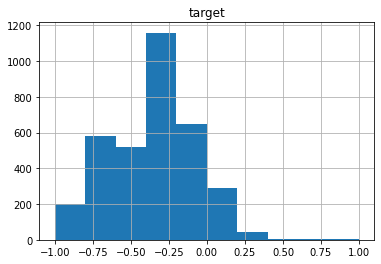

In [10]:
# Min Max Scaler for target
data_cleaned["target"] = np.log(data_cleaned.mrp+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
data_cleaned["target"] = target_scaler.fit_transform(data_cleaned.target.values.reshape(-1,1))
pd.DataFrame(data_cleaned.target).hist()

In [11]:
# Train Test Split
dtrain, dtest = train_test_split(data_cleaned, random_state=123, train_size=0.90)
print(dtrain.shape)
print(dtest.shape)
dtrain.head()

(3101, 8)
(345, 8)


,product_name,brand_name,product_category_wide,mrp,clean_description,seq_description,seq_product_name,target
4479,seamless hipster briefs,9,7,13.00,ultrasoft stretchy microfiber shapes comforta...,"[1688, 49, 389, 694, 95, 98, 208, 1933, 303, 3...","[48, 98, 208]",-0.690375
2199,bridget pushup cotton bra,0,4,32.95,flirt everyday perkiness every girl style 97...,"[569, 73, 630, 89, 159, 5, 1070, 1639, 9, 933,...","[643, 66, 7, 2]",-0.294680
843,aerie everyday loves lace thong,0,7,12.50,introducing everyday loves™ made love everyd...,"[356, 73, 357, 32, 39, 73, 116, 258, 234, 140,...","[14, 73, 116, 1, 8]",-0.706620
324,aerie bikini,0,6,9.50,peek cheek lot wow soft comfy cotton love fi...,"[27, 26, 230, 207, 18, 20, 7, 39, 23, 65, 87, ...","[14, 38]",-0.818881
3247,id logo mesh-panel hipster qf1780,2,7,22.00,kick style notch logo enhanced cooling hipster...,"[1690, 5, 2943, 35, 701, 1889, 98, 54, 59]","[406, 35, 36, 364, 98, 3654]",-0.468620


In [12]:
# Sequence Padding
def get_keras_data(dataset):
    X = {
        'item_name':  pad_sequences(dataset.seq_product_name, maxlen=10),
        'item_desc': pad_sequences(dataset.seq_description, maxlen=75),
        'brand_name': np.array(dataset.brand_name),
        'product_category': np.array(dataset.product_category_wide)
    }
    return X

X_train = get_keras_data(dtrain)
X_test = get_keras_data(dtest)
X_train

{'item_name': array([[   0,    0,    0, ...,   48,   98,  208],
        [   0,    0,    0, ...,   66,    7,    2],
        [   0,    0,    0, ...,  116,    1,    8],
        ...,
        [   0,  165,  133, ...,  288,  452, 3534],
        [   0,    0,    0, ...,  833,   19, 3582],
        [   0,    0,    0, ...,  118,  132,    2]]),
 'item_desc': array([[   0,    0,    0, ...,   62,  304,   23],
        [   0,    0,    0, ...,    3,    3,   11],
        [   0,    0,    0, ...,    3,    3,   11],
        ...,
        [   0,    0,    0, ...,  133,   54,   59],
        [   0,    0,    0, ...,  238,  243,  135],
        [   0,    0,    0, ...,  264,  837, 1243]]),
 'brand_name': array([9, 0, 0, ..., 2, 6, 2]),
 'product_category': array([ 7,  4,  7, ..., 12,  3,  4])}

In [13]:
# Model Fitting
BATCH_SIZE = 2500
epochs = 50

## GRU Based Model

In [14]:
# Model Training
def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_gru_model(optimizer):
    # Params
    dr_r = 0.1
    
    # Inputs
    item_name = Input(shape=[X_train["item_name"].shape[1]], name="item_name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    product_category = Input(shape=[1], name="product_category")
    
    # Embeddings Layers
    emb_item_name = Embedding(MAX_TEXT, 50)(item_name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_product_category = Embedding(MAX_CAT, 10)(product_category)
    
    # RNN Layer
    rnn_layer1 = GRU(16) (emb_item_desc)
    rnn_layer2 = GRU(8) (emb_item_name)
    
    # Main Layer
    main_l = concatenate([
        rnn_layer1,
        rnn_layer2,
        Flatten() (emb_brand_name)
        , Flatten() (emb_product_category)
    ])
    main_l = Dropout(dr_r) (Dense(128) (main_l))
    main_l = Dropout(dr_r) (Dense(64) (main_l))
    
    # Output Layer
    output = Dense(1, activation="linear") (main_l)
    
    # Init Model
    model = Model([item_name, item_desc, brand_name, product_category], output)
    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", rmsle_cust])
    
    return model


# Calculation of Loss History
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

### gru with adam optimizer

In [15]:
adam_gru_model = get_gru_model('adam')

adam_gru_history = LossHistory()
adam_gru_model.summary()
adam_gru_model = get_gru_model('adam')
adam_gru_model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_test, dtest.target)
          , verbose=1, callbacks=[adam_gru_history])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item_desc (InputLayer)         [(None, 75)]         0           []                               
                                                                                                  
 item_name (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 brand_name (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 product_category (InputLayer)  [(None, 1)]          0           []                               
                                                                                              

2/2 [==============================] - 0s 177ms/step - loss: 0.0081 - mae: 0.0651 - rmsle_cust: 0.0060 - val_loss: 0.0118 - val_mae: 0.0816 - val_rmsle_cust: 0.0059
Epoch 23/50
2/2 [==============================] - 1s 193ms/step - loss: 0.0082 - mae: 0.0667 - rmsle_cust: 0.0057 - val_loss: 0.0111 - val_mae: 0.0788 - val_rmsle_cust: 0.0059
Epoch 24/50
2/2 [==============================] - 0s 184ms/step - loss: 0.0074 - mae: 0.0619 - rmsle_cust: 0.0057 - val_loss: 0.0109 - val_mae: 0.0775 - val_rmsle_cust: 0.0059
Epoch 25/50
2/2 [==============================] - 1s 196ms/step - loss: 0.0069 - mae: 0.0598 - rmsle_cust: 0.0056 - val_loss: 0.0111 - val_mae: 0.0785 - val_rmsle_cust: 0.0061
Epoch 26/50
2/2 [==============================] - 0s 191ms/step - loss: 0.0069 - mae: 0.0605 - rmsle_cust: 0.0061 - val_loss: 0.0109 - val_mae: 0.0773 - val_rmsle_cust: 0.0062
Epoch 27/50
2/2 [==============================] - 1s 196ms/step - loss: 0.0067 - mae: 0.0591 - rmsle_cust: 0.0060 - val_loss: 

11/11 [==============================] - 1s 11ms/step
 RMSLE error for GRU Based Model on Test Data: 0.22893180024344015
 RMSE error for GRU Based Model on Test Data: 8.495720831382716


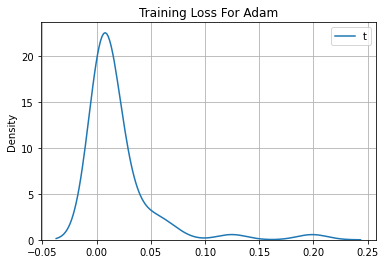

In [16]:
loss_range=np.log(adam_gru_history.losses)
sns.distplot(adam_gru_history.losses, hist=False)
plt.title('Training Loss For Adam')
plt.grid()
plt.legend('top')
val_preds = adam_gru_model.predict(X_test)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

# mean_absolute_error, mean_squared_log_error.
y_true = np.array(dtest.mrp.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
v_rmse = mean_squared_error(y_true, y_pred , squared=False)
print(" RMSLE error for GRU Based Model on Test Data: "+str(v_rmsle))
print(" RMSE error for GRU Based Model on Test Data: "+str(v_rmse))
plt.show()

### gru with stochastic gradient descent optimizer

In [17]:
sgd_gru_model = get_gru_model('sgd')

sgd_gru_history = LossHistory()
sgd_gru_model.summary()
sgd_gru_model = get_gru_model('sgd')
sgd_gru_model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_test, dtest.target)
          , verbose=1, callbacks=[sgd_gru_history])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item_desc (InputLayer)         [(None, 75)]         0           []                               
                                                                                                  
 item_name (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 brand_name (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 product_category (InputLayer)  [(None, 1)]          0           []                               
                                                                                            

2/2 [==============================] - 0s 193ms/step - loss: 0.0734 - mae: 0.2162 - rmsle_cust: 0.0101 - val_loss: 0.0680 - val_mae: 0.2110 - val_rmsle_cust: 0.0077
Epoch 23/50
2/2 [==============================] - 0s 190ms/step - loss: 0.0731 - mae: 0.2161 - rmsle_cust: 0.0101 - val_loss: 0.0678 - val_mae: 0.2107 - val_rmsle_cust: 0.0077
Epoch 24/50
2/2 [==============================] - 1s 221ms/step - loss: 0.0732 - mae: 0.2164 - rmsle_cust: 0.0101 - val_loss: 0.0675 - val_mae: 0.2104 - val_rmsle_cust: 0.0077
Epoch 25/50
2/2 [==============================] - 1s 190ms/step - loss: 0.0729 - mae: 0.2158 - rmsle_cust: 0.0101 - val_loss: 0.0672 - val_mae: 0.2095 - val_rmsle_cust: 0.0077
Epoch 26/50
2/2 [==============================] - 1s 207ms/step - loss: 0.0730 - mae: 0.2157 - rmsle_cust: 0.0101 - val_loss: 0.0670 - val_mae: 0.2093 - val_rmsle_cust: 0.0077
Epoch 27/50
2/2 [==============================] - 1s 182ms/step - loss: 0.0722 - mae: 0.2145 - rmsle_cust: 0.0101 - val_loss: 

11/11 [==============================] - 2s 11ms/step
 RMSLE error for GRU Based Model on Test Data: 0.5582917663436143
 RMSE error for GRU Based Model on Test Data: 20.02797816716318


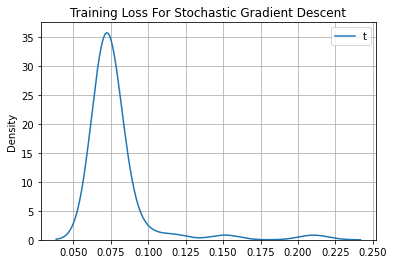

In [18]:
loss_range=np.log(sgd_gru_history.losses)
sns.distplot(sgd_gru_history.losses, hist=False)
plt.title('Training Loss For Stochastic Gradient Descent')
plt.grid()
plt.legend('top')
val_preds = sgd_gru_model.predict(X_test)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

# mean_absolute_error, mean_squared_log_error.
y_true = np.array(dtest.mrp.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
v_rmse = mean_squared_error(y_true, y_pred , squared=False)
print(" RMSLE error for GRU Based Model on Test Data: "+str(v_rmsle))
print(" RMSE error for GRU Based Model on Test Data: "+str(v_rmse))
plt.show()

### gru with adagrad optimizer

In [19]:
adagrad_gru_model = get_gru_model('adagrad')

adagrad_gru_history = LossHistory()
adagrad_gru_model.summary()
adagrad_gru_model = get_gru_model('adagrad')
adagrad_gru_model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_test, dtest.target)
          , verbose=1, callbacks=[adagrad_gru_history])

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item_desc (InputLayer)         [(None, 75)]         0           []                               
                                                                                                  
 item_name (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 brand_name (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 product_category (InputLayer)  [(None, 1)]          0           []                               
                                                                                            

2/2 [==============================] - 0s 197ms/step - loss: 0.0946 - mae: 0.2386 - rmsle_cust: 0.0101 - val_loss: 0.0835 - val_mae: 0.2233 - val_rmsle_cust: 0.0077
Epoch 23/50
2/2 [==============================] - 1s 188ms/step - loss: 0.0932 - mae: 0.2369 - rmsle_cust: 0.0101 - val_loss: 0.0822 - val_mae: 0.2217 - val_rmsle_cust: 0.0077
Epoch 24/50
2/2 [==============================] - 0s 182ms/step - loss: 0.0917 - mae: 0.2352 - rmsle_cust: 0.0101 - val_loss: 0.0810 - val_mae: 0.2202 - val_rmsle_cust: 0.0077
Epoch 25/50
2/2 [==============================] - 0s 182ms/step - loss: 0.0901 - mae: 0.2334 - rmsle_cust: 0.0101 - val_loss: 0.0800 - val_mae: 0.2190 - val_rmsle_cust: 0.0077
Epoch 26/50
2/2 [==============================] - 1s 195ms/step - loss: 0.0892 - mae: 0.2322 - rmsle_cust: 0.0101 - val_loss: 0.0789 - val_mae: 0.2177 - val_rmsle_cust: 0.0077
Epoch 27/50
2/2 [==============================] - 0s 185ms/step - loss: 0.0882 - mae: 0.2313 - rmsle_cust: 0.0101 - val_loss: 

11/11 [==============================] - 2s 11ms/step
 RMSLE error for GRU Based Model on Test Data: 0.5931138712198017
 RMSE error for GRU Based Model on Test Data: 19.81259268614652


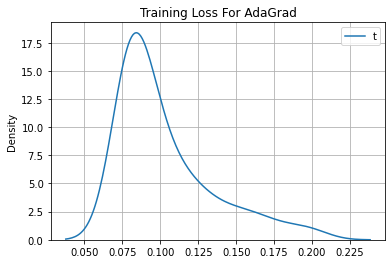

In [20]:
loss_range=np.log(adagrad_gru_history.losses)
sns.distplot(adagrad_gru_history.losses, hist=False)
plt.title('Training Loss For AdaGrad')
plt.grid()
plt.legend('top')
val_preds = adagrad_gru_model.predict(X_test)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

# mean_absolute_error, mean_squared_log_error.
y_true = np.array(dtest.mrp.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
v_rmse = mean_squared_error(y_true, y_pred , squared=False)
print(" RMSLE error for GRU Based Model on Test Data: "+str(v_rmsle))
print(" RMSE error for GRU Based Model on Test Data: "+str(v_rmse))
plt.show()

### Comparison between optimizers

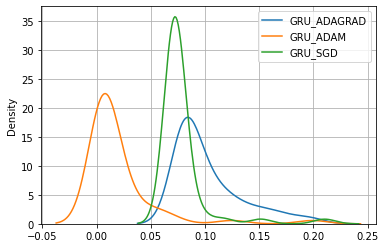

In [21]:
f, ax = plt.subplots(1, 1)
sns.distplot(adagrad_gru_history.losses, hist=False, ax=ax)
sns.distplot(adam_gru_history.losses, hist=False, ax=ax)
sns.distplot(sgd_gru_history.losses, hist=False, ax=ax)
plt.legend(['GRU_ADAGRAD','GRU_ADAM','GRU_SGD'])
plt.grid()

## LSTM Based Model

In [23]:
def get_lstm_model(optimizer):
    # Params
    dr_r = 0.1
    
    # Inputs
    item_name = Input(shape=[X_train["item_name"].shape[1]], name="item_name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    product_category = Input(shape=[1], name="product_category")
    
    # Embeddings Layers
    emb_item_name = Embedding(MAX_TEXT, 50)(item_name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_product_category = Embedding(MAX_CAT, 10)(product_category)
    
    # RNN Layer
    rnn_layer1 = LSTM(16) (emb_item_desc)
    rnn_layer2 = LSTM(8) (emb_item_name)
    
    # Main Layer
    main_l = concatenate([
        rnn_layer1,
        rnn_layer2,
        Flatten() (emb_brand_name)
        , Flatten() (emb_product_category)
    ])
    main_l = Dropout(dr_r) (Dense(128) (main_l))
    main_l = Dropout(dr_r) (Dense(64) (main_l))
    
    # Output Layer
    output = Dense(1, activation="linear") (main_l)
    
    # Init Model
    model = Model([item_name, item_desc, brand_name, product_category], output)
    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", rmsle_cust])
    
    return model

### lstm with adam optimizer

In [24]:
adam_lstm_model = get_lstm_model('adam')

adam_lstm_history = LossHistory()
adam_lstm_model.summary()
adam_lstm_model = get_lstm_model('adam')
adam_lstm_model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_test, dtest.target)
          , verbose=1, callbacks=[adam_lstm_history])

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item_desc (InputLayer)         [(None, 75)]         0           []                               
                                                                                                  
 item_name (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 brand_name (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 product_category (InputLayer)  [(None, 1)]          0           []                               
                                                                                            

2/2 [==============================] - 1s 257ms/step - loss: 0.0087 - mae: 0.0672 - rmsle_cust: 0.0063 - val_loss: 0.0111 - val_mae: 0.0767 - val_rmsle_cust: 0.0055
Epoch 23/50
2/2 [==============================] - 1s 247ms/step - loss: 0.0078 - mae: 0.0633 - rmsle_cust: 0.0063 - val_loss: 0.0108 - val_mae: 0.0758 - val_rmsle_cust: 0.0056
Epoch 24/50
2/2 [==============================] - 1s 254ms/step - loss: 0.0074 - mae: 0.0616 - rmsle_cust: 0.0061 - val_loss: 0.0106 - val_mae: 0.0758 - val_rmsle_cust: 0.0057
Epoch 25/50
2/2 [==============================] - 1s 238ms/step - loss: 0.0070 - mae: 0.0605 - rmsle_cust: 0.0060 - val_loss: 0.0101 - val_mae: 0.0741 - val_rmsle_cust: 0.0057
Epoch 26/50
2/2 [==============================] - 1s 263ms/step - loss: 0.0064 - mae: 0.0586 - rmsle_cust: 0.0060 - val_loss: 0.0097 - val_mae: 0.0731 - val_rmsle_cust: 0.0056
Epoch 27/50
2/2 [==============================] - 1s 285ms/step - loss: 0.0061 - mae: 0.0569 - rmsle_cust: 0.0060 - val_loss: 

11/11 [==============================] - 3s 14ms/step
 RMSLE error for LSTM Based Model on Test Data: 0.21136710941078676
 RMSE error for LSTM Based Model on Test Data: 7.7766440526431415


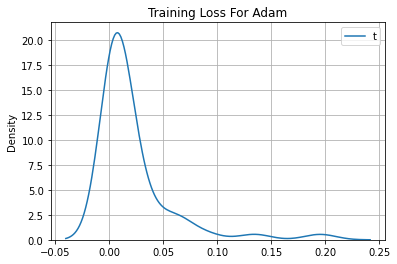

In [25]:
loss_range=np.log(adam_lstm_history.losses)
sns.distplot(adam_lstm_history.losses, hist=False)
plt.title('Training Loss For Adam')
plt.grid()
plt.legend('top')
val_preds = adam_lstm_model.predict(X_test)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

# mean_absolute_error, mean_squared_log_error.
y_true = np.array(dtest.mrp.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
v_rmse = mean_squared_error(y_true, y_pred , squared=False)
print(" RMSLE error for LSTM Based Model on Test Data: "+str(v_rmsle))
print(" RMSE error for LSTM Based Model on Test Data: "+str(v_rmse))
plt.show()

### lstm with stochastic gradient descent optimizer

In [26]:
sgd_lstm_model = get_lstm_model('sgd')

sgd_lstm_history = LossHistory()
sgd_lstm_model.summary()
sgd_lstm_model = get_lstm_model('sgd')
sgd_lstm_model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_test, dtest.target)
          , verbose=1, callbacks=[sgd_lstm_history])

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item_desc (InputLayer)         [(None, 75)]         0           []                               
                                                                                                  
 item_name (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 brand_name (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 product_category (InputLayer)  [(None, 1)]          0           []                               
                                                                                            

2/2 [==============================] - 1s 252ms/step - loss: 0.0771 - mae: 0.2233 - rmsle_cust: 0.0101 - val_loss: 0.0720 - val_mae: 0.2171 - val_rmsle_cust: 0.0077
Epoch 23/50
2/2 [==============================] - 1s 251ms/step - loss: 0.0769 - mae: 0.2230 - rmsle_cust: 0.0101 - val_loss: 0.0717 - val_mae: 0.2167 - val_rmsle_cust: 0.0077
Epoch 24/50
2/2 [==============================] - 1s 257ms/step - loss: 0.0768 - mae: 0.2233 - rmsle_cust: 0.0101 - val_loss: 0.0713 - val_mae: 0.2162 - val_rmsle_cust: 0.0077
Epoch 25/50
2/2 [==============================] - 1s 243ms/step - loss: 0.0760 - mae: 0.2220 - rmsle_cust: 0.0101 - val_loss: 0.0710 - val_mae: 0.2152 - val_rmsle_cust: 0.0077
Epoch 26/50
2/2 [==============================] - 1s 260ms/step - loss: 0.0762 - mae: 0.2220 - rmsle_cust: 0.0101 - val_loss: 0.0706 - val_mae: 0.2149 - val_rmsle_cust: 0.0077
Epoch 27/50
2/2 [==============================] - 1s 313ms/step - loss: 0.0758 - mae: 0.2215 - rmsle_cust: 0.0101 - val_loss: 

11/11 [==============================] - 3s 13ms/step
 RMSLE error for LSTM Based Model on Test Data: 0.5645990034019215
 RMSE error for LSTM Based Model on Test Data: 20.176066492454638


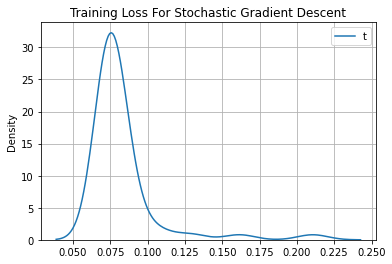

In [27]:
loss_range=np.log(sgd_lstm_history.losses)
sns.distplot(sgd_lstm_history.losses, hist=False)
plt.title('Training Loss For Stochastic Gradient Descent')
plt.grid()
plt.legend('top')
val_preds = sgd_lstm_model.predict(X_test)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

# mean_absolute_error, mean_squared_log_error.
y_true = np.array(dtest.mrp.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
v_rmse = mean_squared_error(y_true, y_pred , squared=False)
print(" RMSLE error for LSTM Based Model on Test Data: "+str(v_rmsle))
print(" RMSE error for LSTM Based Model on Test Data: "+str(v_rmse))
plt.show()

### lstm with adagrad optimizer

In [28]:
adagrad_lstm_model = get_lstm_model('adagrad')

adagrad_lstm_history = LossHistory()
adagrad_lstm_model.summary()
adagrad_lstm_model = get_lstm_model('adagrad')
adagrad_lstm_model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_test, dtest.target)
          , verbose=1, callbacks=[adagrad_lstm_history])

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item_desc (InputLayer)         [(None, 75)]         0           []                               
                                                                                                  
 item_name (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 brand_name (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 product_category (InputLayer)  [(None, 1)]          0           []                               
                                                                                           

2/2 [==============================] - 1s 228ms/step - loss: 0.1074 - mae: 0.2557 - rmsle_cust: 0.0101 - val_loss: 0.0964 - val_mae: 0.2415 - val_rmsle_cust: 0.0077
Epoch 23/50
2/2 [==============================] - 1s 252ms/step - loss: 0.1052 - mae: 0.2527 - rmsle_cust: 0.0101 - val_loss: 0.0949 - val_mae: 0.2393 - val_rmsle_cust: 0.0077
Epoch 24/50
2/2 [==============================] - 1s 285ms/step - loss: 0.1039 - mae: 0.2512 - rmsle_cust: 0.0101 - val_loss: 0.0935 - val_mae: 0.2371 - val_rmsle_cust: 0.0077
Epoch 25/50
2/2 [==============================] - 1s 267ms/step - loss: 0.1021 - mae: 0.2492 - rmsle_cust: 0.0101 - val_loss: 0.0922 - val_mae: 0.2354 - val_rmsle_cust: 0.0077
Epoch 26/50
2/2 [==============================] - 1s 275ms/step - loss: 0.1009 - mae: 0.2474 - rmsle_cust: 0.0101 - val_loss: 0.0909 - val_mae: 0.2336 - val_rmsle_cust: 0.0077
Epoch 27/50
2/2 [==============================] - 1s 267ms/step - loss: 0.0995 - mae: 0.2453 - rmsle_cust: 0.0101 - val_loss: 

11/11 [==============================] - 3s 13ms/step
 RMSLE error for LSTM Based Model on Test Data: 0.6274977557817378
 RMSE error for LSTM Based Model on Test Data: 20.968578123564253


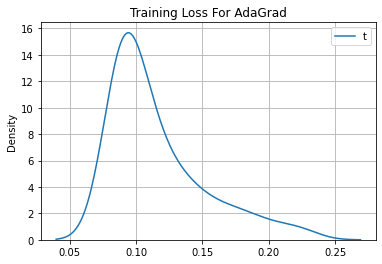

In [29]:
loss_range=np.log(adagrad_lstm_history.losses)
sns.distplot(adagrad_lstm_history.losses, hist=False)
plt.title('Training Loss For AdaGrad')
plt.grid()
plt.legend('top')
val_preds = adagrad_lstm_model.predict(X_test)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

# mean_absolute_error, mean_squared_log_error.
y_true = np.array(dtest.mrp.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
v_rmse = mean_squared_error(y_true, y_pred , squared=False)
print(" RMSLE error for LSTM Based Model on Test Data: "+str(v_rmsle))
print(" RMSE error for LSTM Based Model on Test Data: "+str(v_rmse))
plt.show()

### Comparison between optimizers

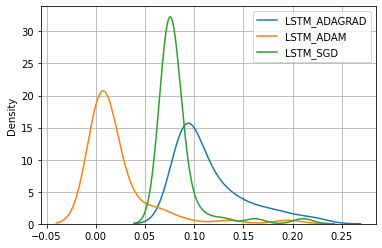

In [30]:
f, ax = plt.subplots(1, 1)
sns.distplot(adagrad_lstm_history.losses, hist=False, ax=ax)
sns.distplot(adam_lstm_history.losses, hist=False, ax=ax)
sns.distplot(sgd_lstm_history.losses, hist=False, ax=ax)
plt.legend(['LSTM_ADAGRAD','LSTM_ADAM','LSTM_SGD'])
plt.grid()

## CNN Based Model

In [32]:
def cnn_model(optimizer, lr=0.001, decay=0.0):

    # Inputs
    item_name = Input(shape=[X_train["item_name"].shape[1]], name="item_name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    product_category = Input(shape=[1], name="product_category")

    # Embeddings layers
    emb_item_name = Embedding(MAX_TEXT, 50)(item_name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_product_category = Embedding(MAX_CAT, 10)(product_category)

    convs1 = []
    convs2 = []
    
    for filter_length in [1,2,3]:
        cnn_layer1 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (emb_item_name)
        cnn_layer2 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (emb_item_desc)
        
        maxpool1 = GlobalMaxPooling1D() (cnn_layer1)
        maxpool2 = GlobalMaxPooling1D() (cnn_layer2)
        
        convs1.append(maxpool1)
        convs2.append(maxpool2)

    convs1 = concatenate(convs1)
    convs2 = concatenate(convs2)
    
    # main layers
    main_l = concatenate([
        convs1,
        convs2,
        Flatten() (emb_brand_name), 
        Flatten() (emb_product_category)
    ])

    main_l = Dense(256)(main_l)
    main_l = Activation('elu')(main_l)

    main_l = Dense(128)(main_l)
    main_l = Activation('elu')(main_l)

    main_l = Dense(64)(main_l)
    main_l = Activation('elu')(main_l)

    # the output layer.
    output = Dense(1, activation="linear") (main_l)

    model = Model([item_name, item_desc, brand_name, product_category], output)

#     optimizer = Adam(lr=lr, decay=decay)
#     model.compile(loss="mse", optimizer=optimizer)
    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", rmsle_cust])

    return model

In [33]:
# Calculate learning rate decay.
exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
steps = int(dtrain.shape[0] / BATCH_SIZE) * epochs
lr_init, lr_fin = 0.007, 0.0005
lr_decay = exp_decay(lr_init, lr_fin, steps)

### cnn with adam optimizer

In [34]:
adam_cnn_model = cnn_model('adam', lr=lr_init, decay=lr_decay)

adam_cnn_history = LossHistory()
adam_cnn_model.summary()
adam_cnn_model = cnn_model('adam', lr=lr_init, decay=lr_decay)
adam_cnn_model.fit(
        X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE,
        validation_data=(X_test, dtest.target), verbose=2, callbacks=[adam_cnn_history]
)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item_name (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 item_desc (InputLayer)         [(None, 75)]         0           []                               
                                                                                                  
 embedding_48 (Embedding)       (None, 10, 50)       195500      ['item_name[0][0]']              
                                                                                                  
 embedding_49 (Embedding)       (None, 75, 50)       195500      ['item_desc[0][0]']              
                                                                                           

Epoch 1/50
2/2 - 3s - loss: 0.2254 - mae: 0.4027 - rmsle_cust: 0.0622 - val_loss: 0.1606 - val_mae: 0.3412 - val_rmsle_cust: 0.0077 - 3s/epoch - 2s/step
Epoch 2/50
2/2 - 1s - loss: 0.1538 - mae: 0.3280 - rmsle_cust: 0.0101 - val_loss: 0.0579 - val_mae: 0.2050 - val_rmsle_cust: 0.0077 - 545ms/epoch - 273ms/step
Epoch 3/50
2/2 - 1s - loss: 0.0611 - mae: 0.2049 - rmsle_cust: 0.0101 - val_loss: 0.0722 - val_mae: 0.2121 - val_rmsle_cust: 0.0077 - 551ms/epoch - 276ms/step
Epoch 4/50
2/2 - 1s - loss: 0.0773 - mae: 0.2211 - rmsle_cust: 0.0101 - val_loss: 0.0692 - val_mae: 0.2098 - val_rmsle_cust: 0.0077 - 548ms/epoch - 274ms/step
Epoch 5/50
2/2 - 1s - loss: 0.0694 - mae: 0.2110 - rmsle_cust: 0.0101 - val_loss: 0.0405 - val_mae: 0.1587 - val_rmsle_cust: 0.0077 - 571ms/epoch - 286ms/step
Epoch 6/50
2/2 - 1s - loss: 0.0404 - mae: 0.1574 - rmsle_cust: 0.0101 - val_loss: 0.0360 - val_mae: 0.1546 - val_rmsle_cust: 0.0077 - 542ms/epoch - 271ms/step
Epoch 7/50
2/2 - 1s - loss: 0.0370 - mae: 0.1522 - r

11/11 [==============================] - 3s 31ms/step
 RMSLE error for CNN Based Model on Test Data: 0.21154162141433683
 RMSE error for CNN Based Model on Test Data: 7.250608823411118


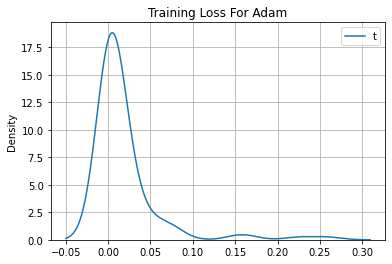

In [35]:
loss_range=np.log(adam_cnn_history.losses)
sns.distplot(adam_cnn_history.losses, hist=False)
plt.title('Training Loss For Adam')
plt.grid()
plt.legend('top')
val_preds = adam_cnn_model.predict(X_test)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

# mean_absolute_error, mean_squared_log_error.
y_true = np.array(dtest.mrp.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
v_rmse = mean_squared_error(y_true, y_pred , squared=False)
print(" RMSLE error for CNN Based Model on Test Data: "+str(v_rmsle))
print(" RMSE error for CNN Based Model on Test Data: "+str(v_rmse))
plt.show()

### cnn with stochastic gradient descent optimizer

In [38]:
sgd_cnn_model = cnn_model('sgd', lr=lr_init, decay=lr_decay)

sgd_cnn_history = LossHistory()
sgd_cnn_model.summary()
sgd_cnn_model = cnn_model('sgd', lr=lr_init, decay=lr_decay)
sgd_cnn_model.fit(
        X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE,
        validation_data=(X_test, dtest.target), verbose=2, callbacks=[sgd_cnn_history]
)

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item_name (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 item_desc (InputLayer)         [(None, 75)]         0           []                               
                                                                                                  
 embedding_64 (Embedding)       (None, 10, 50)       195500      ['item_name[0][0]']              
                                                                                                  
 embedding_65 (Embedding)       (None, 75, 50)       195500      ['item_desc[0][0]']              
                                                                                           

Epoch 1/50
2/2 - 5s - loss: 0.1572 - mae: 0.3201 - rmsle_cust: 0.0103 - val_loss: 0.0929 - val_mae: 0.2351 - val_rmsle_cust: 0.0077 - 5s/epoch - 3s/step
Epoch 2/50
2/2 - 1s - loss: 0.0987 - mae: 0.2438 - rmsle_cust: 0.0101 - val_loss: 0.0786 - val_mae: 0.2192 - val_rmsle_cust: 0.0077 - 787ms/epoch - 393ms/step
Epoch 3/50
2/2 - 1s - loss: 0.0839 - mae: 0.2273 - rmsle_cust: 0.0101 - val_loss: 0.0745 - val_mae: 0.2173 - val_rmsle_cust: 0.0077 - 793ms/epoch - 397ms/step
Epoch 4/50
2/2 - 1s - loss: 0.0794 - mae: 0.2241 - rmsle_cust: 0.0101 - val_loss: 0.0734 - val_mae: 0.2181 - val_rmsle_cust: 0.0077 - 726ms/epoch - 363ms/step
Epoch 5/50
2/2 - 1s - loss: 0.0781 - mae: 0.2239 - rmsle_cust: 0.0101 - val_loss: 0.0730 - val_mae: 0.2184 - val_rmsle_cust: 0.0077 - 756ms/epoch - 378ms/step
Epoch 6/50
2/2 - 1s - loss: 0.0775 - mae: 0.2237 - rmsle_cust: 0.0101 - val_loss: 0.0726 - val_mae: 0.2183 - val_rmsle_cust: 0.0077 - 742ms/epoch - 371ms/step
Epoch 7/50
2/2 - 1s - loss: 0.0770 - mae: 0.2234 - r

11/11 [==============================] - 5s 32ms/step
 RMSLE error for CNN Based Model on Test Data: 0.5479379320493837
 RMSE error for CNN Based Model on Test Data: 19.674448241311588


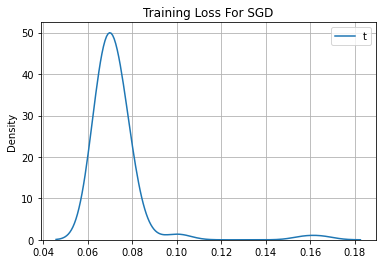

In [40]:
loss_range=np.log(sgd_cnn_history.losses)
sns.distplot(sgd_cnn_history.losses, hist=False)
plt.title('Training Loss For SGD')
plt.grid()
plt.legend('top')
val_preds = sgd_cnn_model.predict(X_test)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

# mean_absolute_error, mean_squared_log_error.
y_true = np.array(dtest.mrp.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
v_rmse = mean_squared_error(y_true, y_pred , squared=False)
print(" RMSLE error for CNN Based Model on Test Data: "+str(v_rmsle))
print(" RMSE error for CNN Based Model on Test Data: "+str(v_rmse))
plt.show()

### cnn with adagrad optimizer

In [41]:
adagrad_cnn_model = cnn_model('adagrad', lr=lr_init, decay=lr_decay)

adagrad_cnn_history = LossHistory()
adagrad_cnn_model.summary()
adagrad_cnn_model = cnn_model('adagrad', lr=lr_init, decay=lr_decay)
adagrad_cnn_model.fit(
        X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE,
        validation_data=(X_test, dtest.target), verbose=2, callbacks=[adagrad_cnn_history]
)

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item_name (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 item_desc (InputLayer)         [(None, 75)]         0           []                               
                                                                                                  
 embedding_72 (Embedding)       (None, 10, 50)       195500      ['item_name[0][0]']              
                                                                                                  
 embedding_73 (Embedding)       (None, 75, 50)       195500      ['item_desc[0][0]']              
                                                                                           

Epoch 1/50
2/2 - 24s - loss: 0.2429 - mae: 0.4200 - rmsle_cust: 0.0567 - val_loss: 0.1861 - val_mae: 0.3549 - val_rmsle_cust: 0.0160 - 24s/epoch - 12s/step
Epoch 2/50
2/2 - 5s - loss: 0.1958 - mae: 0.3676 - rmsle_cust: 0.0171 - val_loss: 0.1552 - val_mae: 0.3174 - val_rmsle_cust: 0.0078 - 5s/epoch - 2s/step
Epoch 3/50
2/2 - 4s - loss: 0.1644 - mae: 0.3301 - rmsle_cust: 0.0102 - val_loss: 0.1327 - val_mae: 0.2894 - val_rmsle_cust: 0.0077 - 4s/epoch - 2s/step
Epoch 4/50
2/2 - 4s - loss: 0.1416 - mae: 0.3010 - rmsle_cust: 0.0101 - val_loss: 0.1166 - val_mae: 0.2685 - val_rmsle_cust: 0.0077 - 4s/epoch - 2s/step
Epoch 5/50
2/2 - 4s - loss: 0.1251 - mae: 0.2789 - rmsle_cust: 0.0101 - val_loss: 0.1049 - val_mae: 0.2524 - val_rmsle_cust: 0.0077 - 4s/epoch - 2s/step
Epoch 6/50
2/2 - 4s - loss: 0.1130 - mae: 0.2628 - rmsle_cust: 0.0101 - val_loss: 0.0962 - val_mae: 0.2402 - val_rmsle_cust: 0.0077 - 4s/epoch - 2s/step
Epoch 7/50
2/2 - 4s - loss: 0.1039 - mae: 0.2503 - rmsle_cust: 0.0101 - val_los

11/11 [==============================] - 1s 11ms/step
 RMSLE error for CNN Based Model on Test Data: 0.5761219575870093
 RMSE error for CNN Based Model on Test Data: 20.452179432130826


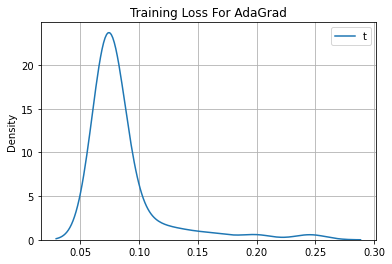

In [42]:
loss_range=np.log(adagrad_cnn_history.losses)
sns.distplot(adagrad_cnn_history.losses, hist=False)
plt.title('Training Loss For AdaGrad')
plt.grid()
plt.legend('top')
val_preds = adagrad_cnn_model.predict(X_test)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

# mean_absolute_error, mean_squared_log_error.
y_true = np.array(dtest.mrp.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
v_rmse = mean_squared_error(y_true, y_pred , squared=False)
print(" RMSLE error for CNN Based Model on Test Data: "+str(v_rmsle))
print(" RMSE error for CNN Based Model on Test Data: "+str(v_rmse))
plt.show()

### Comparison between optimizers

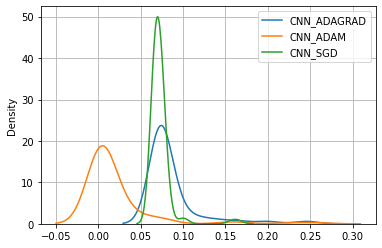

In [43]:
f, ax = plt.subplots(1, 1)
sns.distplot(adagrad_cnn_history.losses, hist=False, ax=ax)
sns.distplot(adam_cnn_history.losses, hist=False, ax=ax)
sns.distplot(sgd_cnn_history.losses, hist=False, ax=ax)
plt.legend(['CNN_ADAGRAD','CNN_ADAM','CNN_SGD'])
plt.grid()

# Predicting the Price using the best performant model

In [44]:
# Predict the price.
preds = adam_cnn_model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1
dtest["predicted_price"] = preds
dtest.head()

1/1 [==============================] - 0s 132ms/step


,product_name,brand_name,product_category_wide,mrp,clean_description,seq_description,seq_product_name,target,predicted_price
3619,logo to go low rise thong 631581,6,7,22.00,soft sheer lace wraps around waist lightweigh...,"[18, 72, 1, 1261, 521, 161, 264, 20, 8, 83, 90]","[35, 87, 65, 21, 16, 8, 1980]",-0.468620,27.218317
3444,lace plunge bra,12,4,35.00,elegant black plunge bra prettified gorgeous l...,"[488, 133, 80, 2, 2973, 238, 1, 711, 109, 324,...","[1, 80, 2]",-0.268490,29.763096
2517,classic mesh triangle bralette,6,3,54.00,classic silhouettes airy stretch mesh,"[100, 682, 616, 34, 36]","[100, 36, 68, 19]",-0.079174,46.388378
3076,happy unlined bandeau bra,0,4,26.95,hello happy bras happiness feeling like real...,"[240, 52, 92, 148, 269, 150, 12, 235, 360, 52,...","[52, 169, 312, 2]",-0.381549,26.861637
5635,b.provocative contrast-lace bra 951222,1,4,40.00,flattering sheer nude panels decorated intrica...,"[215, 72, 393, 781, 999, 571, 1250, 325, 3311,...","[67, 686, 216, 1, 2, 3892]",-0.210396,38.623650
